# **Import Libraries**

In this section, I import the main libraries I will use for data handling, NLP models, and machine learning.

In [22]:
# Import Libraries
import pandas as pd
import numpy as np

# HuggingFace Transformers
from transformers import pipeline

# Machine Learning Tools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# **Load Dataset**

In [23]:
# Load dataset (clean version after editing in Excel)
df = pd.read_csv("bbc-news-data.csv", encoding="latin-1")

# Show first 5 rows
df.head()


,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


# **Data Cleaning**

In this section,I clean the text data to prepare it for NLP models.

In [24]:
import re #re: for search and deal with text

# Drop missing values
df = df.dropna().reset_index(drop=True)

# Function to clean text
def clean_text(text):
    text = str(text)
    text = text.lower()  # lowercase
    text = re.sub(r'\n', ' ', text)  # remove new lines
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

# Apply cleaning on "content" column
df["clean_content"] = df["content"].apply(clean_text)

# Show sample after cleaning
df[["content", "clean_content"]].head(3)


,content,clean_content
0,Quarterly profits at US media giant TimeWarne...,quarterly profits at us media giant timewarner...
1,The dollar has hit its highest level against ...,the dollar has hit its highest level against t...
2,The owners of embattled Russian oil giant Yuk...,the owners of embattled russian oil giant yuko...


# **Semantic Search**

In this section, I implement a simple semantic search using Sentence-BERT to get the most similar articles.

In [25]:
# Install sentence-transformers
!pip install -q sentence-transformers


In [26]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load a pre-trained model
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Encode the cleaned content into embeddings
embeddings = model.encode(df["clean_content"].tolist(), convert_to_tensor=True)

# Example query
query = "كرة القدم"# or oil prices and economy
query_embedding = model.encode([query])

# Calculate cosine similarity
similarities = cosine_similarity(query_embedding, embeddings)[0]

# Get top 3 results
top_idx = similarities.argsort()[-3:][::-1]
df.iloc[top_idx][["title", "category", "content"]]

,title,category,content
1495,Mourinho expects fight to finish,sport,Chelsea manager Jose Mourinho expects the Cha...
1509,FA probes crowd trouble,sport,The FA is to take action after trouble marred...
1416,Chelsea clinch cup in extra-time,sport,(after extra-time - score at 90 mins 1-1) Jo...


# **شرح توضيحي لعملية البحث :**
نستورد مكتبتين :  
* SentenceTransformer: لتحميل موديل جاهز يحول النصوص إلى vectors (أرقام) تمثل معناها.

*   cosine_similarity: دالة تقيس مدى التشابه بين النصوص بناءً على الـ vectors.

نستدعي موديل جاهز من HuggingFace :

*   هذا الموديل يدعم أكثر من 50 لغة (منها العربي + الإنجليزي).

*   وظيفته: يأخذ أي نص → ويرجعه كـ vector (مجموعة أرقام تعبر عن المعنى).

ناخذ كل النصوص اللي في عمود clean_content (المقالات بعد التنظيف).

*   encode يحول كل مقال إلى vector.
*   الناتج embeddings: مصفوفة ضخمة فيها تمثيل رقمي لكل مقال.


نكتب استفسار (Query) — هنا مثال: "oil prices and economy".

نحوله أيضًا إلى vector (query_embedding).

الآن صار عندنا:

*   vectors للمقالات.

*   vector للاستفسار.

نحسب مدى التشابه بين الاستفسار وكل مقال.

1.   cosine_similarity يعطيك رقم من 0 إلى 1:

*   1 = متشابه جدًا.

*   0 = ماله علاقة.

2.   الناتج: قائمة أرقام، كل رقم يمثل درجة التشابه مع مقال معيّن.

argsort() يرتب المقالات حسب درجة التشابه.



*   [-3:] نأخذ أعلى 3 مقالات.
*   [::-1] نخليها بالترتيب التنازلي (الأكثر تشابه أول).
*   نعرض الأعمدة المهمة: title, category, content.

# **Add Similarity Scores**

This section adds a similarity score to each retrieved article to show how close it is to the query.-> لمعرفة درجة التشابه

In [27]:
# Get top results with similarity scores
results = df.iloc[top_idx][["title", "category", "content"]].copy()

# Add similarity column
results["similarity"] = similarities[top_idx]

# Show results
results


,title,category,content,similarity
1495,Mourinho expects fight to finish,sport,Chelsea manager Jose Mourinho expects the Cha...,0.56605
1509,FA probes crowd trouble,sport,The FA is to take action after trouble marred...,0.55044
1416,Chelsea clinch cup in extra-time,sport,(after extra-time - score at 90 mins 1-1) Jo...,0.54855


# **Summarization**

This section uses a pre-trained model to generate a short summary from a long article.

In [28]:
from transformers import pipeline

# Load summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Pick one article (for eg,the first result from semantic search)
text = df.iloc[top_idx[0]]["content"]

# Generate summary
summary = summarizer(text, max_length=130, min_length=30, do_sample=False)

print("Original Text (first 500 chars):")
print(text[:500], "...")

print("\nGenerated Summary:")
print(summary[0]['summary_text'])


Device set to use cpu


Original Text (first 500 chars):
 Chelsea manager Jose Mourinho expects the Champions League clash with Barcelona to be a fight to the finish.  Mourinho is relishing the first leg of the tie against his former club in the last 16 in the Nou Camp. He said: "I wouldn't be surprised if nothing had been decided by the last minute of the return leg and the match had to go into extra time. "I have to defend what is mine and the Champions League is mine at the moment. I'm the last manager to have won it." Mourinho never coached Barcel ...

Generated Summary:
Jose Mourinho is relishing the first leg of the tie against his former club in the last 16 in the Nou Camp. Mourinho never coached Barcelona, assisting both Sir Bobby Robson and Louis van Gaal. Barcelona star Ronaldinho admitted: "I think that it is going to be a difficult match for us because Chelsea have a good team full of big stars"


# **Auto Classification**

# **Prepare Data**

Select text and labels, drop missing rows, and inspect class counts.

In [29]:
# Text (features) and labels (targets)
X_text = df["clean_content"].fillna("")
y = df["category"].fillna("")

# Basic sanity check
print("Total samples:", len(X_text))
print(y.value_counts())


Total samples: 2225
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


# **Train / Test Split**

Split the data into training and testing sets.

In [30]:
from sklearn.model_selection import train_test_split

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

len(X_train_text), len(X_test_text)


(1780, 445)

# **Vectorize with TF-IDF**

Convert text into numeric features using TF-IDF.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train_text)
X_test  = vectorizer.transform(X_test_text)

X_train.shape, X_test.shape


((1780, 5000), (445, 5000))

# **Train Classifier (Logistic Regression)**

Train a simple linear model for multi-class text classification.

In [32]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000, n_jobs=-1)  # max iteration for learning
clf.fit(X_train, y_train)


LogisticRegression(max_iter=1000, n_jobs=-1)

# **Evaluate Model**

Check accuracy and per-class metrics.

In [33]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = clf.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.9798

Classification Report:

               precision    recall  f1-score   support

     business       0.96      0.98      0.97       102
entertainment       0.99      1.00      0.99        77
     politics       0.98      0.94      0.96        84
        sport       0.99      1.00      1.00       102
         tech       0.99      0.97      0.98        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



In [34]:
import pandas as pd

cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
cm


Predicted,business,entertainment,politics,sport,tech
Actual,,,,,
business,100,0,1,1,0
entertainment,0,77,0,0,0
politics,3,1,79,0,1
sport,0,0,0,102,0
tech,1,0,1,0,78


# **Visualize Model Performance**

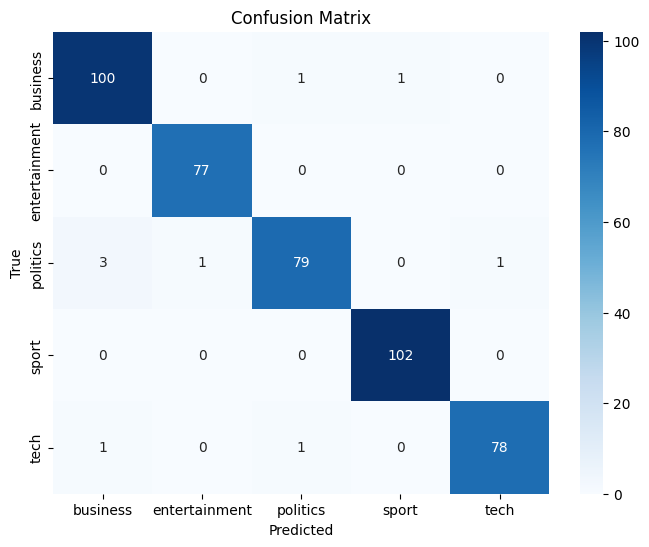

Model Accuracy: 0.98


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=clf.classes_,
            yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Accuracy بسيط
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")


# **Predict on New Text**

Classify any new article (or use one from your dataset).

In [36]:
# Example: new unseen texts
new_texts = [
    "The stock market faced a huge drop this week due to oil prices.",
    "The football team won the championship yesterday.",
    "The prime minister announced new policies about education."
]

# Convert them into the same TF-IDF representation
new_embeddings = vectorizer.transform(new_texts)

# Predict categories
predictions = clf.predict(new_embeddings)

# Show results
for text, label in zip(new_texts, predictions):
    print(f"Text: {text}\nPredicted Category: {label}\n{'-'*50}")


Text: The stock market faced a huge drop this week due to oil prices.
Predicted Category: business
--------------------------------------------------
Text: The football team won the championship yesterday.
Predicted Category: sport
--------------------------------------------------
Text: The prime minister announced new policies about education.
Predicted Category: politics
--------------------------------------------------


# **Save Model & Vectorizer**

In [38]:
import joblib

# نحفظ الموديل والـ vectorizer في ملفات
joblib.dump(clf, "classifier_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("✅ Model and Vectorizer saved successfully!")


✅ Model and Vectorizer saved successfully!


In [42]:
from google.colab import files

# نزول الموديل
files.download("classifier_model.pkl")

# نزول الـ vectorizer
files.download("tfidf_vectorizer.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>